# Optimal trajectoy generation in Frenet frame
Refs:
- "Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenet Frame"
- https://github.com/AtsushiSakai/PythonRobotics

In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import copy
import sys 
from IPython.display import clear_output
import math
%matplotlib inline

In [2]:
with open('./map/map_coord.pickle', 'rb') as fr:
    map_coord = pickle.load(fr)

In [3]:
map_coord.keys()

dict_keys(['Lane_inner', 'Lane_center', 'Lane_outer', 'waypoint_inner', 'waypoint_outer'])

In [4]:
map_in = map_coord['Lane_inner']
map_center = map_coord['Lane_center']
map_out = map_coord['Lane_outer']
wp_in = map_coord['waypoint_inner']
wp_out = map_coord['waypoint_outer']

map_center.shape

(237, 2)

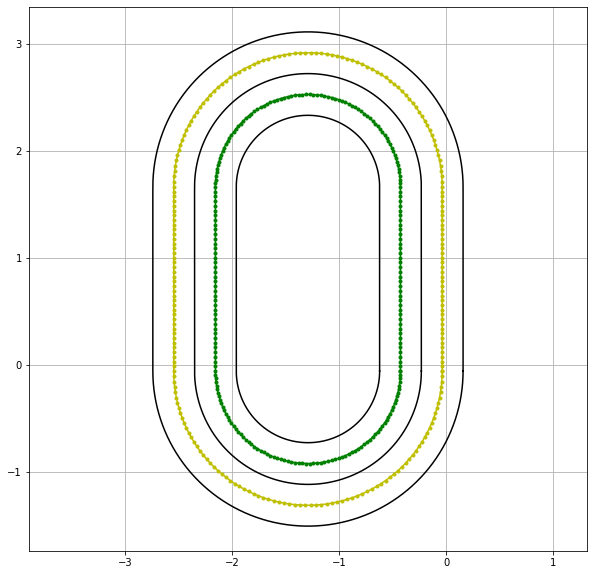

In [5]:
plt.figure(figsize=(10,10))
plt.plot(map_center[:,0], map_center[:,1], 'k')
plt.plot(map_in[:,0], map_in[:,1], 'k')
plt.plot(map_out[:,0], map_out[:,1], 'k')
plt.plot(wp_in[:,0], wp_in[:,1], 'g.-')
plt.plot(wp_out[:,0], wp_out[:,1], 'y.-')
plt.axis('equal')
plt.grid('on')

## Frenet Optimal Trajectory Planner

In [6]:
def next_waypoint(x, y, mapx, mapy):
    closest_wp = get_closest_waypoints(x, y, mapx, mapy)
    
    map_vec = [mapx[closest_wp + 1] - mapx[closest_wp], mapy[closest_wp + 1] - mapy[closest_wp]]
    ego_vec = [x - mapx[closest_wp], y - mapy[closest_wp]]

    direction  = np.sign(np.dot(map_vec, ego_vec))

    if direction >= 0:
        next_wp = closest_wp + 1
    else:
        next_wp = closest_wp
    
    return next_wp

    
def get_closest_waypoints(x, y, mapx, mapy):
    min_len = 1e10
    closeset_wp = 0
    
    for i in range(len(mapx)):
        _mapx = mapx[i]
        _mapy = mapy[i]
        dist = get_dist(x, y, _mapx, _mapy)   
        
        if dist < min_len:
            min_len = dist
            closest_wp = i     
            
    return closest_wp

            
def get_dist(x, y, _x, _y):
    return np.sqrt((x - _x)**2 + (y - _y)**2)

In [7]:
def get_frenet(x, y, mapx, mapy):
    next_wp = next_waypoint(x, y, mapx, mapy)
    prev_wp = next_wp -1
    
    n_x = mapx[next_wp] - mapx[prev_wp]
    n_y = mapy[next_wp] - mapy[prev_wp]
    x_x = x - mapx[prev_wp]
    x_y = y - mapy[prev_wp]
    
    proj_norm = (x_x*n_x+x_y*n_y)/(n_x*n_x+n_y*n_y)
    proj_x = proj_norm*n_x
    proj_y = proj_norm*n_y
    
    #-------- get frenet d
    frenet_d = get_dist(x_x,x_y,proj_x,proj_y)
    
    ego_vec = [x-mapx[prev_wp], y-mapy[prev_wp], 0];
    map_vec = [n_x, n_y, 0];
    d_cross = np.cross(ego_vec,map_vec)
    if d_cross[-1] > 0:
        frenet_d = -frenet_d;
    
    #-------- get frenet s
    frenet_s = 0;
    for i in range(prev_wp):
        frenet_s = frenet_s + get_dist(mapx[i],mapy[i],mapx[i+1],mapy[i+1]);

    frenet_s = frenet_s + get_dist(0,0,proj_x,proj_y);

    return frenet_s, frenet_d

In [8]:
def get_cartesian(s, d, mapx, mapy, maps):
    prev_wp = 0
    
    s = np.mod(s, maps[-2])
    
    while(s > maps[prev_wp+1]) and (prev_wp < len(maps)-2):
        prev_wp = prev_wp + 1
    
    next_wp = np.mod(prev_wp+1,len(mapx))
    
    dx = (mapx[next_wp]-mapx[prev_wp])
    dy = (mapy[next_wp]-mapy[prev_wp])
    
    heading = np.arctan2(dy, dx) # [rad]
    
    # the x,y,s along the segment
    seg_s = s - maps[prev_wp];

    seg_x = mapx[prev_wp] + seg_s*np.cos(heading);
    seg_y = mapy[prev_wp] + seg_s*np.sin(heading);

    perp_heading = heading + 90 * np.pi/180; 
    x = seg_x + d*np.cos(perp_heading);
    y = seg_y + d*np.sin(perp_heading);

    return x, y, heading

In [9]:
# initialize 
V_MAX = 2      # maximum velocity [m/s]
ACC_MAX = 2 # maximum acceleration [m/ss]
K_MAX = 4     # maximum curvature [1/m]

TARGET_SPEED = 1 # target speed [m/s]
LANE_WIDTH = 0.39  # lane width [m]

COL_CHECK = 0.25 # collision check distance [m]

MIN_T = 1 # minimum terminal time [s]
MAX_T = 2 # maximum terminal time [s]
DT_T = 0.5 # dt for terminal time [s] : MIN_T 에서 MAX_T 로 어떤 dt 로 늘려갈지를 나타냄
DT = 0.1 # timestep for update

# cost weights
K_J = 0.1 # weight for jerk
K_T = 0.1 # weight for terminal time
K_D = 1.0 # weight for consistency
K_V = 1.0 # weight for getting to target speed
K_LAT = 1.0 # weight for lateral direction
K_LON = 1.0 # weight for longitudinal direction 

SIM_STEP = 500 # simulation step 
SHOW_ANIMATION = True # plot 으로 결과 보여줄지 말지

# Vehicle parameters - plot 을 위한 파라미터
LENGTH = 0.39  # [m]
WIDTH = 0.19  # [m]
BACKTOWHEEL = 0.1  # [m]
WHEEL_LEN = 0.03  # [m]
WHEEL_WIDTH = 0.02  # [m]
TREAD = 0.07  # [m]
WB = 0.22  # [m]

In [10]:
class QuinticPolynomial:

    def __init__(self, xi, vi, ai, xf, vf, af, T):
        # calculate coefficient of quintic polynomial
        # used for lateral trajectory
        self.a0 = xi
        self.a1 = vi
        self.a2 = 0.5*ai

        A = np.array([[T**3, T**4, T**5],
                      [3*T**2, 4*T**3, 5*T** 4],
                      [6*T, 12*T**2, 20*T**3]])
        b = np.array([xf - self.a0 - self.a1*T - self.a2*T**2,
                      vf - self.a1 - 2*self.a2*T,
                      af - 2*self.a2])
        x = np.linalg.solve(A, b)

        self.a3 = x[0]
        self.a4 = x[1]
        self.a5 = x[2]

    # calculate postition info.
    def calc_pos(self, t):
        x = self.a0 + self.a1*t + self.a2*t**2 + self.a3*t**3 + self.a4*t**4 + self.a5 * t ** 5
        return x

    # calculate velocity info.
    def calc_vel(self, t):
        v = self.a1 + 2*self.a2*t + 3*self.a3*t**2 + 4*self.a4*t**3 + 5*self.a5*t**4
        return v

    # calculate acceleration info.
    def calc_acc(self, t):
        a = 2*self.a2 + 6*self.a3*t + 12*self.a4*t**2 + 20*self.a5*t**3
        return a

    # calculate jerk info.
    def calc_jerk(self, t):
        j = 6*self.a3 + 24*self.a4*t + 60*self.a5*t**2
        return j

In [11]:
class QuarticPolynomial:
    
    def __init__(self, xi, vi, ai, vf, af, T):
        # calculate coefficient of quartic polynomial
        # used for longitudinal trajectory
        self.a0 = xi
        self.a1 = vi
        self.a2 = 0.5*ai
        
        A = np.array([[3*T**2, 4*T**3],
                             [6*T, 12*T**2]])
        b = np.array([vf - self.a1 - 2*self.a2*T,
                             af - 2*self.a2])
        
        x = np.linalg.solve(A, b)
        
        self.a3 = x[0]
        self.a4 = x[1]
        
    # calculate postition info.
    def calc_pos(self, t):
        x = self.a0 + self.a1*t + self.a2*t**2 + self.a3*t**3 + self.a4*t**4
        return x
 
    # calculate velocity info.
    def calc_vel(self, t):
        v = self.a1 + 2*self.a2*t + 3*self.a3*t**2 + 4*self.a4*t**3
        return v
 
    # calculate acceleration info.
    def calc_acc(self, t):
        a = 2*self.a2 + 6*self.a3*t + 12*self.a4*t**2
        return a

    # calculate jerk info.
    def calc_jerk(self, t):
        j = 6*self.a3 + 24*self.a4*t
        return j

In [12]:
class FrenetPath:
    
    def __init__(self):
        # time
        self.t = []
        
        # lateral traj in Frenet frame
        self.d = []
        self.d_d = []
        self.d_dd = []
        self.d_ddd = []
        
        # longitudinal traj in Frenet frame
        self.s = []
        self.s_d = []
        self.s_dd = []
        self.s_ddd = []
        
        # cost
        self.c_lat = 0.0
        self.c_lon = 0.0
        self.c_tot = 0.0

        # combined traj in global frame
        self.x = []
        self.y = []
        self.yaw = []
        self.ds = []
        self.kappa = []

In [13]:
def calc_frenet_paths(si, si_d, si_dd, sf_d, sf_dd, di, di_d, di_dd, df_d, df_dd, opt_d):
    frenet_paths = []

    # generate path to each offset goal
    for df in DF_SET:

        # Lateral motion planning
        for T in np.arange(MIN_T, MAX_T+DT_T, DT_T):
            fp = FrenetPath()
            lat_traj = QuinticPolynomial(di, di_d, di_dd, df, df_d, df_dd, T)

            fp.t = [t for t in np.arange(0.0, T, DT)]
            fp.d = [lat_traj.calc_pos(t) for t in fp.t]
            fp.d_d = [lat_traj.calc_vel(t) for t in fp.t]
            fp.d_dd = [lat_traj.calc_acc(t) for t in fp.t]
            fp.d_ddd = [lat_traj.calc_jerk(t) for t in fp.t]

            # Longitudinal motion planning (velocity keeping)
            tfp = copy.deepcopy(fp)
            lon_traj = QuarticPolynomial(si, si_d, si_dd, sf_d, sf_dd, T)

            tfp.s = [lon_traj.calc_pos(t) for t in fp.t]
            tfp.s_d = [lon_traj.calc_vel(t) for t in fp.t]
            tfp.s_dd = [lon_traj.calc_acc(t) for t in fp.t]
            tfp.s_ddd = [lon_traj.calc_jerk(t) for t in fp.t]

            # 경로 늘려주기 (In case T < MAX_T)
            for _t in np.arange(T, MAX_T, DT):
                tfp.t.append(_t)
                tfp.d.append(tfp.d[-1])
                _s = tfp.s[-1] + tfp.s_d[-1] * DT
                tfp.s.append(_s)
                
                tfp.s_d.append(tfp.s_d[-1])
                tfp.s_dd.append(tfp.s_dd[-1])
                tfp.s_ddd.append(tfp.s_ddd[-1])      
                
                tfp.d_d.append(tfp.d_d[-1])
                tfp.d_dd.append(tfp.d_dd[-1])
                tfp.d_ddd.append(tfp.d_ddd[-1])

            J_lat = sum(np.power(tfp.d_ddd, 2))  # lateral jerk
            J_lon = sum(np.power(tfp.s_ddd, 2))  # longitudinal jerk

            # cost for consistency
            d_diff = (tfp.d[-1] - opt_d) ** 2
            # cost for target speed
            v_diff = (TARGET_SPEED - tfp.s_d[-1]) ** 2

            # lateral cost
            tfp.c_lat = K_J * J_lat + K_T * T + K_D * d_diff
            # logitudinal cost
            tfp.c_lon = K_J * J_lon + K_T * T + K_V * v_diff
            
            # total cost combined
            tfp.c_tot = K_LAT * tfp.c_lat + K_LON * tfp.c_lon

            frenet_paths.append(tfp)

    return frenet_paths

In [14]:
def calc_global_paths(fplist, mapx, mapy, maps):

    # transform trajectory from Frenet to Global
    for fp in fplist:
        for i in range(len(fp.s)):
            _s = fp.s[i]
            _d = fp.d[i]
            _x, _y, _ = get_cartesian(_s, _d, mapx, mapy, maps)
            fp.x.append(_x)
            fp.y.append(_y)

        for i in range(len(fp.x) - 1):
            dx = fp.x[i + 1] - fp.x[i]
            dy = fp.y[i + 1] - fp.y[i]
            fp.yaw.append(np.arctan2(dy, dx))
            fp.ds.append(np.hypot(dx, dy))

        fp.yaw.append(fp.yaw[-1])
        fp.ds.append(fp.ds[-1])

        # calc curvature
        for i in range(len(fp.yaw) - 1):
            yaw_diff = fp.yaw[i + 1] - fp.yaw[i]
            yaw_diff = np.arctan2(np.sin(yaw_diff), np.cos(yaw_diff))
            fp.kappa.append(yaw_diff / fp.ds[i])

    return fplist

In [15]:
def collision_check(fp, obs, mapx, mapy, maps):
    for i in range(len(obs[:, 0])):
        # get obstacle's position (x,y)
        obs_xy = get_cartesian( obs[i, 0], obs[i, 1], mapx, mapy, maps)
        
        d = [((_x - obs_xy[0]) ** 2 + (_y - obs_xy[1]) ** 2)
             for (_x, _y) in zip(fp.x, fp.y)]

        collision = any([di <= COL_CHECK ** 2 for di in d])

        if collision:
            return True

    return False

In [16]:
def check_path(fplist, obs, mapx, mapy, maps):
    ok_ind = []
    for i, _path in enumerate(fplist):
        acc_squared = [(abs(a_s**2 + a_d**2)) for (a_s, a_d) in zip(_path.s_dd, _path.d_dd)]
        if any([v > V_MAX for v in _path.s_d]):  # Max speed check
            continue
        elif any([acc > ACC_MAX**2 for acc in acc_squared]):
            continue
        elif any([abs(kappa) > K_MAX for kappa in fplist[i].kappa]):  # Max curvature check
            continue
        elif collision_check(_path, obs, mapx, mapy, maps):
            continue

        ok_ind.append(i)

    return [fplist[i] for i in ok_ind]

In [17]:
def frenet_optimal_planning(si, si_d, si_dd, sf_d, sf_dd, di, di_d, di_dd, df_d, df_dd, obs, mapx, mapy, maps, opt_d):
    fplist = calc_frenet_paths(si, si_d, si_dd, sf_d, sf_dd, di, di_d, di_dd, df_d, df_dd, opt_d)
    fplist = calc_global_paths(fplist, mapx, mapy, maps)
    
    fplist = check_path(fplist, obs, mapx, mapy, maps)
    # find minimum cost path
    min_cost = float("inf")
    opt_traj = None
    opt_ind = 0
    for fp in fplist:
        if min_cost >= fp.c_tot:
            min_cost = fp.c_tot
            opt_traj = fp
            _opt_ind = opt_ind
        opt_ind += 1     

    try:
        _opt_ind
    except NameError:
        print(" No solution ! ")
        
    return fplist, _opt_ind

In [18]:
def plot_car(x, y, yaw, steer=0.0, cabcolor="-r", truckcolor="-k"):  # pragma: no cover

    outline = np.array([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                        [WIDTH / 2, WIDTH / 2, - WIDTH / 2, -WIDTH / 2, WIDTH / 2]])

    fr_wheel = np.array([[WHEEL_LEN, -WHEEL_LEN, -WHEEL_LEN, WHEEL_LEN, WHEEL_LEN],
                         [-WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, WHEEL_WIDTH - TREAD, -WHEEL_WIDTH - TREAD]])

    rr_wheel = np.copy(fr_wheel)

    fl_wheel = np.copy(fr_wheel)
    fl_wheel[1, :] *= -1
    rl_wheel = np.copy(rr_wheel)
    rl_wheel[1, :] *= -1

    Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                     [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.array([[math.cos(steer), math.sin(steer)],
                     [-math.sin(steer), math.cos(steer)]])

    fr_wheel = (fr_wheel.T.dot(Rot2)).T
    fl_wheel = (fl_wheel.T.dot(Rot2)).T
    fr_wheel[0, :] += WB
    fl_wheel[0, :] += WB

    fr_wheel = (fr_wheel.T.dot(Rot1)).T
    fl_wheel = (fl_wheel.T.dot(Rot1)).T

    outline = (outline.T.dot(Rot1)).T
    rr_wheel = (rr_wheel.T.dot(Rot1)).T
    rl_wheel = (rl_wheel.T.dot(Rot1)).T

    outline[0, :] += x
    outline[1, :] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fr_wheel[0, :]).flatten(),
             np.array(fr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rr_wheel[0, :]).flatten(),
             np.array(rr_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(fl_wheel[0, :]).flatten(),
             np.array(fl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(np.array(rl_wheel[0, :]).flatten(),
             np.array(rl_wheel[1, :]).flatten(), truckcolor)
    plt.plot(x, y, "*")

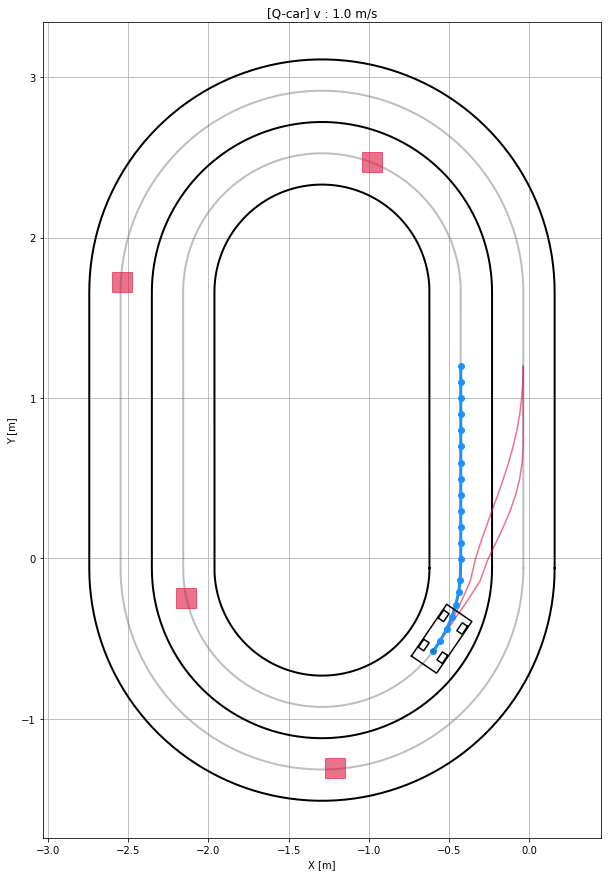

In [20]:
# map waypoints
mapx = map_center[:,0]
mapy = map_center[:,1]

# static obstacles
obs = np.array([[3.0, WIDTH],
               [5, -WIDTH],
               [7, WIDTH],
               [8.5, -WIDTH]
               ])


# get maps
maps = np.zeros(mapx.shape)
for i in range(len(mapx)):
    x = mapx[i]
    y = mapy[i]
    sd = get_frenet(x, y, mapx, mapy)
    maps[i] = sd[0]
    
    
# get global position info. of static obstacles
obs_global = np.zeros(obs.shape)
for i in range(len(obs[:,0])):
    _s = obs[i,0]
    _d = obs[i,1]
    xy = get_cartesian(_s, _d, mapx, mapy, maps)
    obs_global[i] = xy[:-1]


# 자챠량 관련 initial condition
x = -LANE_WIDTH
y = 0
yaw = 90 * np.pi/180
v = 0.5
a = 0

s, d = get_frenet(x, y, mapx, mapy);
x, y, yaw_road = get_cartesian(s, d, mapx, mapy, maps)
yawi = yaw - yaw_road

# s 방향 초기조건
si = s
si_d = v*np.cos(yawi)
si_dd = a*np.cos(yawi)
sf_d = TARGET_SPEED
sf_dd = 0

# d 방향 초기조건
di = d
di_d = v*np.sin(yawi)
di_dd = a*np.sin(yawi)
df_d = 0
df_dd = 0

opt_d = di

# lateral planning 시 terminal position condition 후보  (양 차선 중앙)
DF_SET = np.array([LANE_WIDTH/2, -LANE_WIDTH/2])

# 시뮬레이션 수행 (SIM_STEP 만큼)
for step in range(SIM_STEP):

    # optimal planning 수행 (output : valid path & optimal path index)
    path, opt_ind = frenet_optimal_planning(si, si_d, si_dd, 
                                            sf_d, sf_dd, di, di_d, di_dd, df_d, df_dd, obs, mapx, mapy, maps, opt_d)
    
    '''
    다음 시뮬레이션 step 에서 사용할 initial condition update.
    본 파트에서는 planning 만 수행하고 control 은 따로 수행하지 않으므로,
    optimal trajectory 중 현재 위치에서 한개 뒤 index 를 다음 step 의 초기초건으로 사용.
    ''' 
    si = path[0].s[1]
    si_d = path[0].s_d[1]
    si_dd = path[0].s_dd[1] 
    di = path[0].d[1]
    di_d = path[0].d_d[1]
    di_dd = path[0].d_dd[1]
    
    # consistency cost를 위해 update
    opt_d = path[opt_ind].d[-1]
    
    if SHOW_ANIMATION:  # pragma: no cover
        plt.figure(figsize=(10,15))
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])

        plt.plot(map_center[:,0], map_center[:,1], 'k', linewidth=2)
        plt.plot(map_in[:,0], map_in[:,1], 'k', linewidth=2)
        plt.plot(map_out[:,0], map_out[:,1], 'k', linewidth=2)
        plt.plot(wp_in[:,0], wp_in[:,1], color='slategray', linewidth=2, alpha=0.5)
        plt.plot(wp_out[:,0], wp_out[:,1], color='slategray', linewidth=2, alpha=0.5)

        # plot obstacle
        for ob in obs_global:
            plt.plot(ob[0], ob[1], "s", color="crimson", MarkerSize=20, alpha=0.6)
        
        for i in range(len(path)):
                plt.plot(path[i].x, path[i].y, "-", color="crimson", linewidth=1.5, alpha=0.6)

        plt.plot(path[opt_ind].x, path[opt_ind].y, "o-", color="dodgerblue", linewidth=3)

        # plot car
        plot_car(path[opt_ind].x[0], path[opt_ind].y[0], path[opt_ind].yaw[0], steer=0)
        
        plt.axis('equal')
        plt.title("[Q-car] v : " + str(si_d)[0:4] + " m/s")
        plt.grid(True)
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")

        plt.pause(0.001)
#         input("Press enter to continue...")
        
        plt.show()
        clear_output(wait=True)

